In [ ]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 26 07:03:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#########################################################################
## MONTAR DRIVE
#########################################################################
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#########################################################################
## CONFIGURAR WANDB
#########################################################################
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 9.8 MB/s 
     |████████████████████████████████| 145 kB 50.6 MB/s 
     |████████████████████████████████| 181 kB 47.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=77ac8681783cc299ce608382c34be316e21e063a0a491b37ca5b28a4170d542b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#########################################################################
## CARGAR LAS LIBRERÍAS NECESARIAS
#########################################################################
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.datasets import mnist
import numpy as np

from random import shuffle,seed

import seaborn as sns

from tensorflow.keras import layers

from keras import metrics
import keras.utils

import os

from tensorflow import keras

In [ ]:
#########################################################################
## INICIAR WANDB
#########################################################################
import wandb
from wandb.keras import WandbCallback

In [ ]:
#############################################################################
## Variables globales
#############################################################################
batch_size =32 
epochs = 100  
lr = 1e-3
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
latent_dim=128

In [ ]:
################################################################################################################
## CARGAMOS EL CONJUNTO DE DATOS CELEBA
###############################################################################################################
!gdown --id '15xe3XLynYMt65PXaA4iTKq4mXECACdN3' -O images.zip
!mkdir ./img_align_celeba
!unzip -qq ./images.zip -d img_align_celeba/1

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15xe3XLynYMt65PXaA4iTKq4mXECACdN3
To: /content/images.zip
100% 1.44G/1.44G [00:17<00:00, 80.2MB/s]


In [ ]:
#Directorio que contendra las imagenes reales
dataset_directory = "./img_align_celeba" 

In [ ]:
#Procesamos el conjunto de datos para quedarnos con conjuntos total_imagenes/batch size imagenes de tamaño (64,64) y tomamos dos conjuntos de forma aleatoria para x_train y x_test
# https://runebook.dev/es/docs/tensorflow/keras/preprocessing/image_dataset_from_directory
x_train = keras.preprocessing.image_dataset_from_directory(
    dataset_directory, label_mode=None, shuffle=True, image_size=(64, 64), batch_size=batch_size
) 

x_test = keras.preprocessing.image_dataset_from_directory(
    dataset_directory, label_mode=None, shuffle=True, image_size=(64, 64), batch_size=batch_size
)

#Normalizamos a escala [0,1]
x_train = x_train.map(lambda x: x / 255.0)
x_test = x_test.map(lambda x: x / 255.0)


print(x_train.__len__())
print(x_test.cardinality())


Found 202599 files belonging to 1 classes.
Found 202599 files belonging to 1 classes.
tf.Tensor(6332, shape=(), dtype=int64)
tf.Tensor(6332, shape=(), dtype=int64)


In [ ]:
# Transformar a estructura numpy

# x_train
images = np.empty((1, 64, 64, 3))
i = 0
for x in x_train.unbatch():
  images = np.append(images, [x], axis = 0)
  i = i + 1
  if i > 50: # sacamos un mini-conjunto de 50 imágenes    
    break

# x_test
images_test = np.empty((1, 64, 64, 3))
i = 0
for x in x_test.unbatch():
  images_test = np.append(images_test, [x], axis = 0)
  i = i + 1
  if i > 50: # sacamos un mini-conjunto de 50 imágenes    
    break

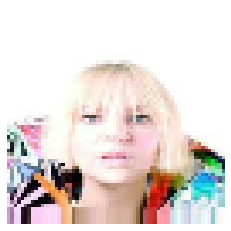

In [ ]:
for x in x_train:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
################################################################################################################
## CLASE WGAN
###############################################################################################################
class WGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim, 
                 discriminator_extra_steps=3, gp_weight=10.0):
        super(WGAN, self).__init__()
        
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    # Evaluación del Discriminador
    def evaluate_D(self):
      #Generamos las imágenes a partir del espacio latente y el generador
      batch_size = tf.shape(images)[0]
      random_latent_vectors = tf.random.normal( shape=(batch_size, self.latent_dim))
      generated_images = self.generator(random_latent_vectors)
      
      #Compilamos el modelo discriminador
      self.discriminator.compile(optimizer=self.d_optimizer,loss=self.d_loss_fn,metrics=['accuracy'])
      
      #Evaluación del discriminador con las imágenes reales
      loss_real, acc_real = self.discriminator.evaluate(images_test,tf.ones((batch_size, 1),dtype=tf.dtypes.float32), verbose=1)

      #Evaluación del discriminador con las imágenes falsas
      loss_fake, acc_fake = self.discriminator.evaluate(generated_images,tf.zeros((batch_size, 1),dtype=tf.dtypes.float32) , verbose=1)

      # Mostramos por pantalla un resumen 
      print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
      print('>Loss real: ')
      print(loss_real)
      print('>Loss fake: ')
      print(loss_fake)
      
    # Evaluación del Generador
    def evaluate_G(self):
      #Generamos las imágenes a partir del espacio latente y el generador
      batch_size = tf.shape(images)[0]
      random_latent_vectors = tf.random.normal( shape=(batch_size, self.latent_dim))
      generated_images = self.generator(random_latent_vectors)

      #Visualizamos varias imágenes generadas seleccionadas de forma aleatoria
      for i in range(9):
          random_latent_vectors = tf.random.normal(
        shape=(9, 128))
          pred = generator(random_latent_vectors )
          plt.subplot(331 + i)
          plt.axis('off')
          plt.imshow(np.squeeze(pred[0]), cmap='gray')
      plt.show()


    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Imagen interpolada
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
      if isinstance(real_images, tuple):
          real_images = real_images[0]

      batch_size = tf.shape(real_images)[0]

      #ENTRENAMIENTO DEL DISCRIMINADOR: se entrena al discriminador varias veces entre cada actualización del generador.
      for i in range(self.d_steps):
          # Vector latente
          random_latent_vectors = tf.random.normal(
              shape=(batch_size, self.latent_dim)
          )
          with tf.GradientTape() as tape:
              #Generamos la imagen falsa
              fake_images = self.generator(random_latent_vectors, training=True)
              # Obtenemos los logits de la imagen falsa
              fake_logits = self.discriminator(fake_images, training=True)  
           

              # Obtenemos los logits de la imagen real
              real_logits = self.discriminator(real_images, training=True)
             

              # Calculamos la pérdida del discriminador usando los logits de la imagen real y falsa
              d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
           
              # Calculamos la penalización del gradiente
              gp = self.gradient_penalty(batch_size, real_images, fake_images)
              # Añadimos la penalizacion del gradiente a la pérdida del discriminador
              d_loss = d_cost + gp * self.gp_weight

          # Obtenemos el gradiente w.r.t de la función de  pérdida del discriminador
          d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
          # Actualizamos los pesos del modelo DISCRIMINADOR usando el optimizador del discriminador
          self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

      # ENTRENAMIENTO DEL GENERADOR
      random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
      with tf.GradientTape() as tape:
          # Generamos la imagen falsa a traves del generador
          generated_images = self.generator(random_latent_vectors, training=True)
          # Obtenemos los logits del discriminador en la imagen falsa
          gen_img_logits = self.discriminator(generated_images, training=True)
          # Calculamos la función de pérdida del generador
          g_loss = self.g_loss_fn(gen_img_logits)

      # Conseguimos el gradiente w.r.t de la pérdida del generador
      gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
      # Actualizamos los pesos del GENERATOR usando el optimizador del generador
      self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
      return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
################################################################################################################
## Función para mostrar por pantalla 9 imágenes reales, 9 imagenes reales con ruido 
## y 9 imágenes generadas por nuestro modelo generador
###############################################################################################################
def generated_images_plot(original, noised_data, generator):
    """Plot subplot of images during training."""
    print('NOISED')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(noised_data[i]), cmap='gray')
    plt.show()
    
    print('GENERATED')
    for i in range(9):
        random_latent_vectors = tf.random.normal(
      shape=(9, 128))
        pred = generator(random_latent_vectors )
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(pred[0]), cmap='gray')
    plt.show()
    print('ORIGINAL')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(original[i]), cmap='gray')
    plt.show()


In [ ]:
################################################################################
# Declaramos optimizadores y funciones de pérdida del generador-discriminador
#################################################################################
generator_optimizer = tf.keras.optimizers.Adam(
	learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

discriminator_optimizer =tf.keras.optimizers.Adam(
	learning_rate=0.0001, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# EXPERIMENTO 1

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)               

In [ ]:
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16*16*128),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             4227072   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      147584    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 64)       73792     
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 64)        0 

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
          config= {
               "learning_rate": 0.0001,
               "epochs": epochs,
               "num_imagenes": 6332,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

# Definimos el modelo WGAN.
wgan = WGAN(discriminator=discriminator,
			       generator=generator,
            latent_dim=latent_dim,
            discriminator_extra_steps=5,)

# Compilacion
wgan.compile(d_optimizer=discriminator_optimizer,
			 g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)

# Entrenamiento
wgan.fit(x_train, epochs=epochs, callbacks=[WandbCallback()])

                                                                                                                                                                                                                                  

wandb: Currently logged in as: ugr-sail (sail-ugr). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
6332/6332 [==============================] - 489s 75ms/step - d_loss: -4.2657 - g_loss: -6.1231 - _timestamp: 1652944749.0000 - _runtime: 494.0000
Epoch 2/100
6332/6332 [==============================] - 476s 75ms/step - d_loss: -2.2269 - g_loss: 11.7765 - _timestamp: 1652945242.0000 - _runtime: 987.0000
Epoch 3/100
6332/6332 [==============================] - 476s 75ms/step - d_loss: -2.0510 - g_loss: 13.1269 - _timestamp: 1652945743.0000 - _runtime: 1488.0000
Epoch 4/100
6332/6332 [==============================] - 474s 75ms/step - d_loss: -1.7818 - g_loss: 5.8561 - _timestamp: 1652946218.0000 - _runtime: 1963.0000
Epoch 5/100
6332/6332 [==============================] - 474s 75ms/step - d_loss: -1.5855 - g_loss: 2.4284 - _timestamp: 1652946719.0000 - _runtime: 2464.0000
Epoch 6/100
6332/6332 [==============================] - 475s 75ms/step - d_loss: -1.4345 - g_loss: 3.2645 - _timestamp: 1652947223.0000 - _runtime: 2968.0000
Epoch 7/100
6332/6332 [======================

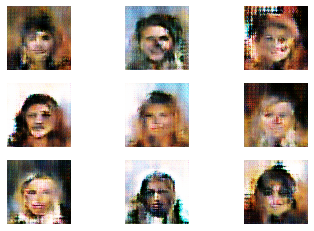

2/2 [==============================] - 0s 8ms/step - loss: -580.3474 - accuracy: 1.0000
>Accuracy real: 2%, fake: 100%
>Loss real: 
2905913132318720.0
>Loss fake: 
-580.3473510742188


In [ ]:
#Evaluación

wgan.evaluate_G()

wgan.evaluate_D()

# EXPERIMENTO 2
DISCRIMINADOR: Aumentamos la tasa del dropout y disminuimos el learning rate del optimizador 

In [ ]:
generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16*16*128),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      147584    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 64)       73792     
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0 

In [ ]:
discriminator2 = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(1),
    ],
    name="discriminator2",
)
discriminator2.summary()

Model: "discriminator2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 1)              

In [ ]:
opt_d=tf.keras.optimizers.Adam(learning_rate = 1e-6)

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
          config= {
               "learning_rate": 1e-6,
               "epochs": epochs,
               "num_imagenes": 6332,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

#Definición del modelo GAN
wgan = WGAN(discriminator=discriminator2,
			generator=generator,
            latent_dim=latent_dim,
            discriminator_extra_steps=5,)

# Compilacion
wgan.compile(d_optimizer=opt_d, 
			 g_optimizer=generator_optimizer,
             g_loss_fn=generator_loss,
             d_loss_fn=discriminator_loss,)


#Entrenamiento
history=wgan.fit(
  x_train , epochs=epochs, callbacks=[WandbCallback()]
)

wandb.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
6332/6332 [==============================] - 511s 78ms/step - d_loss: 6.0787 - g_loss: -0.9277 - _timestamp: 1653549255.0000 - _runtime: 517.0000
Epoch 2/100
6332/6332 [==============================] - 492s 78ms/step - d_loss: 4.5481 - g_loss: -1.4125 - _timestamp: 1653549803.0000 - _runtime: 1065.0000
Epoch 3/100
6332/6332 [==============================] - 489s 77ms/step - d_loss: 3.2741 - g_loss: -1.9132 - _timestamp: 1653550301.0000 - _runtime: 1563.0000
Epoch 4/100
6332/6332 [==============================] - 489s 77ms/step - d_loss: 2.5101 - g_loss: -1.9515 - _timestamp: 1653550803.0000 - _runtime: 2065.0000
Epoch 5/100
6332/6332 [==============================] - 497s 78ms/step - d_loss: 1.9247 - g_loss: -2.2238 - _timestamp: 1653551299.0000 - _runtime: 2561.0000
Epoch 6/100
6332/6332 [==============================] - 495s 78ms/step - d_loss: 1.4223 - g_loss: -2.8042 - _timestamp: 1653551800.0000 - _runtime: 3062.0000
Epoch 7/100
6332/6332 [========================

d_loss,█▆▅▄▃▆▁▃▄▁▂▃▃▄▂▃▂▃▃▃▃▃▂▃▅▄▂▂▄▆▃▄▃▄▃▇▄▅▄▃
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
g_loss,▄▃▂▁▃▄▂▂▅▁▃▃▂▃▃▄▄▆▄▂▅▄▄▅█▅▅▆▅▅▆▄▃▄▅▄▅▅▄▂
d_loss,-0.73971
epoch,99
g_loss,-3.19439


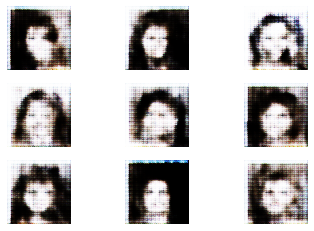

2/2 [==============================] - 0s 11ms/step - loss: 3.0373 - accuracy: 0.0000e+00
>Accuracy real: 100%, fake: 0%
>Loss real: 
1596498131288064.0
>Loss fake: 
3.0373053550720215


In [ ]:
#Evaluación
wgan.evaluate_G()

wgan.evaluate_D()

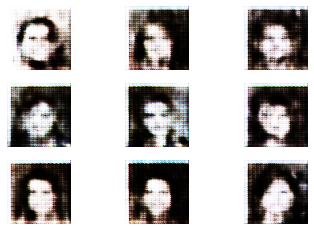

2/2 [==============================] - 0s 12ms/step - loss: 2.8762 - accuracy: 0.0000e+00
>Accuracy real: 100%, fake: 0%
>Loss real: 
1596498131288064.0
>Loss fake: 
2.8762433528900146


In [ ]:
#Evaluación
wgan.evaluate_G()

wgan.evaluate_D()


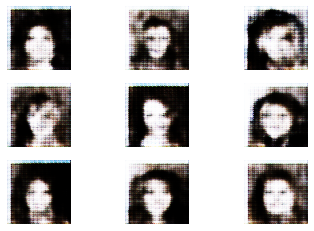

2/2 [==============================] - 0s 13ms/step - loss: 2.8817 - accuracy: 0.0000e+00
>Accuracy real: 98%, fake: 0%
>Loss real: 
nan
>Loss fake: 
2.8817460536956787


In [ ]:
#Evaluación
wgan.evaluate_G()

wgan.evaluate_D()

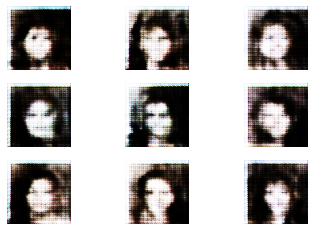

2/2 [==============================] - 0s 9ms/step - loss: 2.8370 - accuracy: 0.0000e+00
>Accuracy real: 98%, fake: 0%
>Loss real: 
nan
>Loss fake: 
2.8369863033294678


In [ ]:
#Evaluación
wgan.evaluate_G()

wgan.evaluate_D()